In [51]:
import os
from os.path import join
import sys
sys.path.append("../")
import matplotlib.pyplot as plt

import random
import SimpleITK as sitk


from DataAnalyzer import DataAnalyzer
from time import perf_counter

DATA_ROOT = "/home/guest/work/Datasets"

paths = {
    "picai_labels_wg" : "picai_labels_all/picai_labels-main/anatomical_delineations/whole_gland/AI/Guerbet23",
    "picai_labels_zonal" : "picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23",
    "picai_folds" : "picai_folds/picai_images_fold0"
}

analyzer = DataAnalyzer(DATA_ROOT)


> Every patient case will at least have three imaging sequences: axial T2W, axial DWI and axial ADC scans (i.e. files ending in _t2w.mha, _hbv.mha, _adc.mha). Additionally, they can also have either, both or none of these optional imaging sequences: sagittal and coronal T2W scans (i.e. files ending in _sag.mha, _cor.mha here). 

Vemos que algunos pacientes tienen imágenes adicionales

In [2]:
pth = os.path.join(paths["picai_folds"])
folds = analyzer.get_dirs(pth)

for fold in folds:
    rel = os.path.join(pth, fold)
    dirs = analyzer.get_dirs(rel)
    incomplete_dirs = []
    total = 0

    for dir in dirs:
        # check if they all have 5 files
        rel2 = os.path.join(rel, dir)
        
        files = analyzer.get_files(rel2)

        if len(list(files)) != 5:
            print(f"Directory {dir} has {
                # do this because the analyzer returns a generator
                len(list(analyzer.get_files(rel2)))} files, expected 5.")
            incomplete_dirs.append(dir)
        total += 1

    print(f"Number of non-matching directories: {len(incomplete_dirs)}")

    print("Total file count excluding the previous non-matching: ", (total - len(incomplete_dirs) ) * 5)



Directory 10129 has 10 files, expected 5.
Directory 11383 has 10 files, expected 5.
Directory 10193 has 10 files, expected 5.
Directory 11087 has 10 files, expected 5.
Directory 10540 has 10 files, expected 5.
Number of non-matching directories: 5
Total file count excluding the previous non-matching:  1450


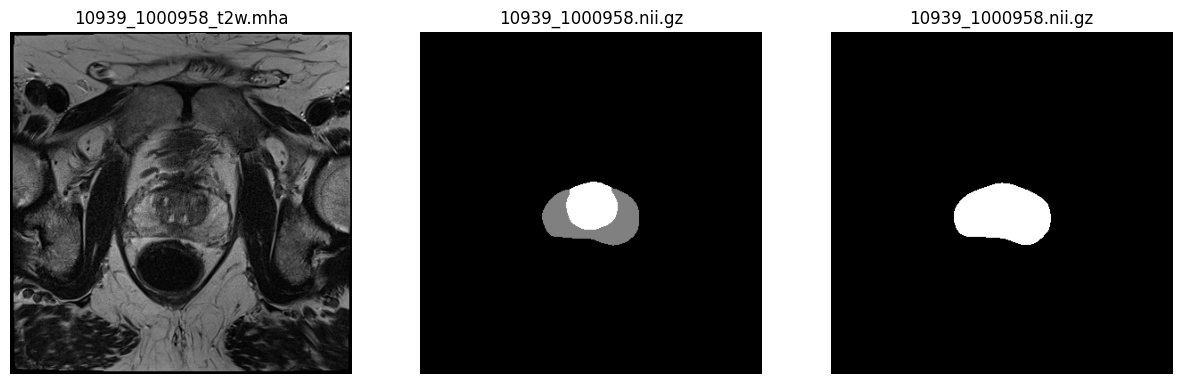

In [57]:

# pick a random folder and set the name of a file inside as the prefix
dirs = list(analyzer.get_dirs(d))
random_dir = random.choice(dirs)
files_in_dir = analyzer.get_files(join(paths["picai_folds"], random_dir), ".*_t2w.mha$")

# we have to do this because get files is a generator
name = next(files_in_dir)
i1 = join(paths["picai_folds"], random_dir, name)

# get the corresponding nii.gz file that masks the image
nii = name.split("_t2w")[0].split("/")[-1] + ".nii.gz"
i2 = join(paths['picai_labels_zonal'], nii)

# get the whole gland mask
i3 = join(paths['picai_labels_wg'], nii)

analyzer.show_image(i1, i2, i3, save="/home/guest/code")


Let's look for possible empty masks, since some of the lesion data was missing

In [4]:
analyzer.regex = r".*mha$"
non_empty_count, empty_masks = analyzer.count_and_find_non_empty_masks(paths['picai_labels_zonal'])
print(f"{non_empty_count} out of {non_empty_count+len(empty_masks)} masks are non-empty (contain a segmentation).")
print("Empty mask files:", empty_masks)

0 out of 0 masks are non-empty (contain a segmentation).
Empty mask files: []


Is the whole gland the sum of the zonal masks?

A we see th ewhole gland is sligtly bigger in most cases, indicating it's not just the sum. 
This might be due to differences in the model used for automatic labeling.

/home/guest/work/Datasets/picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/10985_1001004.nii.gz
/home/guest/work/Datasets/picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/11094_1001117.nii.gz
/home/guest/work/Datasets/picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/10181_1000184.nii.gz
/home/guest/work/Datasets/picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/10195_1000199.nii.gz
/home/guest/work/Datasets/picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/11159_1001182.nii.gz
/home/guest/work/Datasets/picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23/10617_1000631.nii.gz


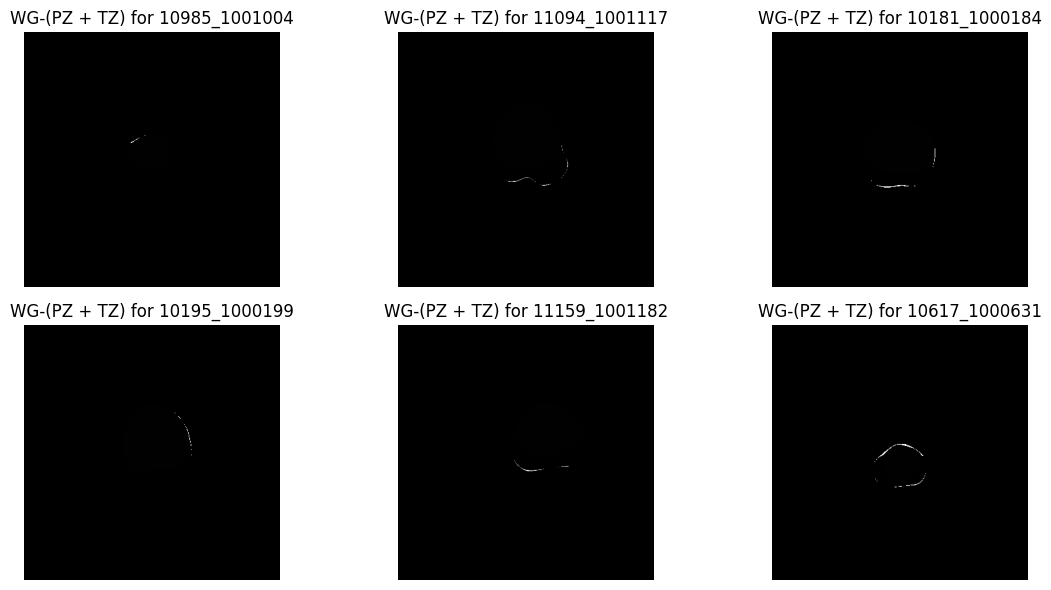

In [48]:

# pick a random folder and set the name of a file inside as the prefix
d = "picai_folds/picai_images_fold0"
dirs = list(analyzer.get_dirs(d))
random_dir = random.choices(dirs, k=6)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))  # Create a 3x2 figure with axes
axes = axes.flatten()  # Flatten the axes array for easier indexing

for idx, dir in enumerate(random_dir):
    files_in_dir = analyzer.get_files(join(d, dir), ".*_t2w.mha$")

    # We have to do this because get_files is a generator
    name = next(files_in_dir)

    # Get the corresponding nii.gz file that masks the image
    nii = os.path.basename(name).split("_t2w")[0] + ".nii.gz"
    i2 = join(DATA_ROOT, paths['picai_labels_zonal'], nii)
    print(i2)


    # Get the whole gland mask
    i3 = join(DATA_ROOT, paths['picai_labels_wg'], nii)

    # Turn the images into arrays, set all labels >= 1 to 1
    # Then, do the difference between both and display it to see where they differ
    i2 = sitk.ReadImage(i2)
    image_array = sitk.GetArrayViewFromImage(i2)
    image_array[image_array >= 1]
    #print(image_array[image_array.shape[0] // 2, :, :])

    i3 = sitk.ReadImage(i3)
    i3_array = sitk.GetArrayViewFromImage(i3)
    i3_array[i3_array >= 1]
    #print(i3_array[i3_array.shape[0] // 2, :, :])

    diff = (image_array - i3_array)
    diff[diff >= 1] # Keep only positive differences
    diff = diff[image_array.shape[0] // 2, :, :] # take the middle slice by default
    
    # Plot the image diff on the corresponding axis
    axes[idx].imshow(diff, cmap='gray')
    axes[idx].set_title(f"WG-(PZ + TZ) for {os.path.basename(name).split('_t2w')[0]}")
    axes[idx].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


#analyzer.show_image(i2, i3, save="../combined_images.png")

Now, we use the function the analyzer to analyze the metadata.

In [6]:
# use this regex to filter the files
analyzer.regex = "(.*_t2w.mha$)|(.*_sag.mha$)|(.*_cor.mha$)"
res = analyzer.collect_metadata_to_dataframe("picai_folds/picai_images_fold0/10189")
print(res)

start = perf_counter()
df = analyzer.collect_metadata_from_subdirs("picai_folds/picai_images_fold0")
print(df)
print(perf_counter() - start, "seconds")

                filename        dim_size              spacing orientation  \
0  10189_1000192_cor.mha  (320, 320, 19)      (0.6, 0.6, 3.6)         RSA   
1  10189_1000192_t2w.mha  (640, 640, 21)      (0.3, 0.3, 3.6)         RAI   
2  10189_1000192_sag.mha  (320, 320, 21)  (0.562, 0.562, 3.6)         ASL   

   prostate_volume   vendor    mri_name  psa_report  
0            125.0  SIEMENS  Prisma_fit        5.97  
1            125.0  SIEMENS  Prisma_fit        5.97  
2            125.0  SIEMENS  Prisma_fit        5.97  
                  filename        dim_size              spacing orientation  \
0    10961_1000980_t2w.mha  (384, 384, 21)      (0.5, 0.5, 3.0)         RAI   
1    10961_1000980_sag.mha  (320, 320, 19)  (0.562, 0.562, 3.6)         ASL   
2    10961_1000980_cor.mha  (320, 320, 17)      (0.6, 0.6, 3.0)         RSA   
3    10851_1000867_t2w.mha  (384, 384, 21)      (0.5, 0.5, 3.0)         RAI   
4    10851_1000867_sag.mha  (320, 320, 19)  (0.562, 0.562, 3.6)         ASL   
.

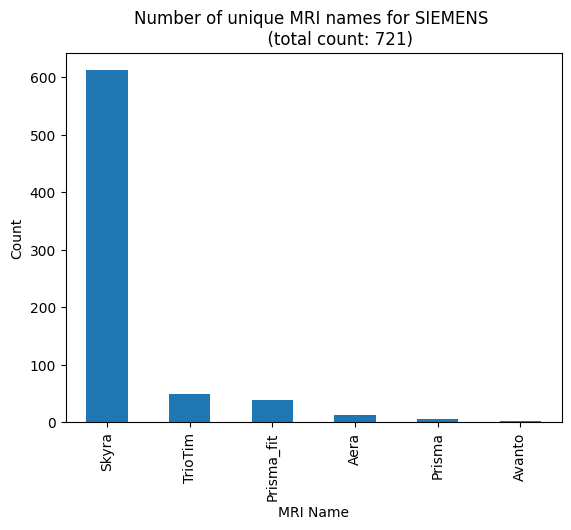

In [7]:
# for all the rows with vendor SIEMENS, get number of unique mri_names
siemens_mri_names = df[df['vendor'] == 'SIEMENS']['mri_name'].value_counts()

import matplotlib.pyplot as plt
siemens_mri_names.plot(kind='bar')
plt.title("""Number of unique MRI names for SIEMENS 
          (total count: {})""".format(siemens_mri_names.sum()))
plt.xlabel("MRI Name")
plt.ylabel("Count")
plt.show()

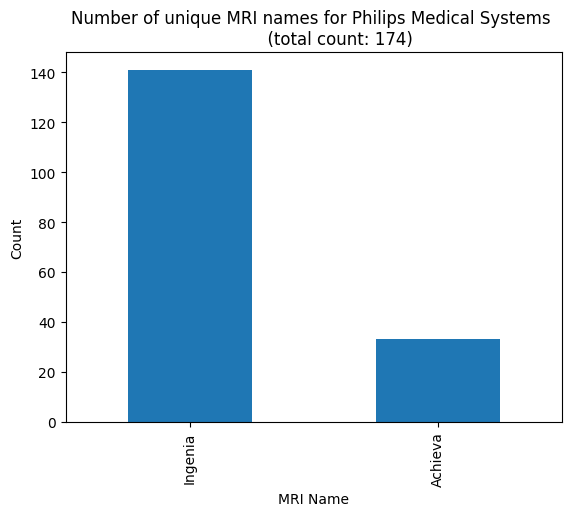

In [8]:
# for all the rows with vendor Philips Medical Systems, get number of unique mri_names
phl_mri_names = df[df['vendor'] == 'Philips Medical Systems']['mri_name'].value_counts()

# plot in a bar graph
import matplotlib.pyplot as plt
phl_mri_names.plot(kind='bar')
plt.title("""Number of unique MRI names for Philips Medical Systems 
          (total count: {})""".format(phl_mri_names.sum()))
plt.xlabel("MRI Name")
plt.ylabel("Count")
plt.show()

Now, we are interested in the dimensons and resolutions of the data, and how they are distrubuted trough the dataset.

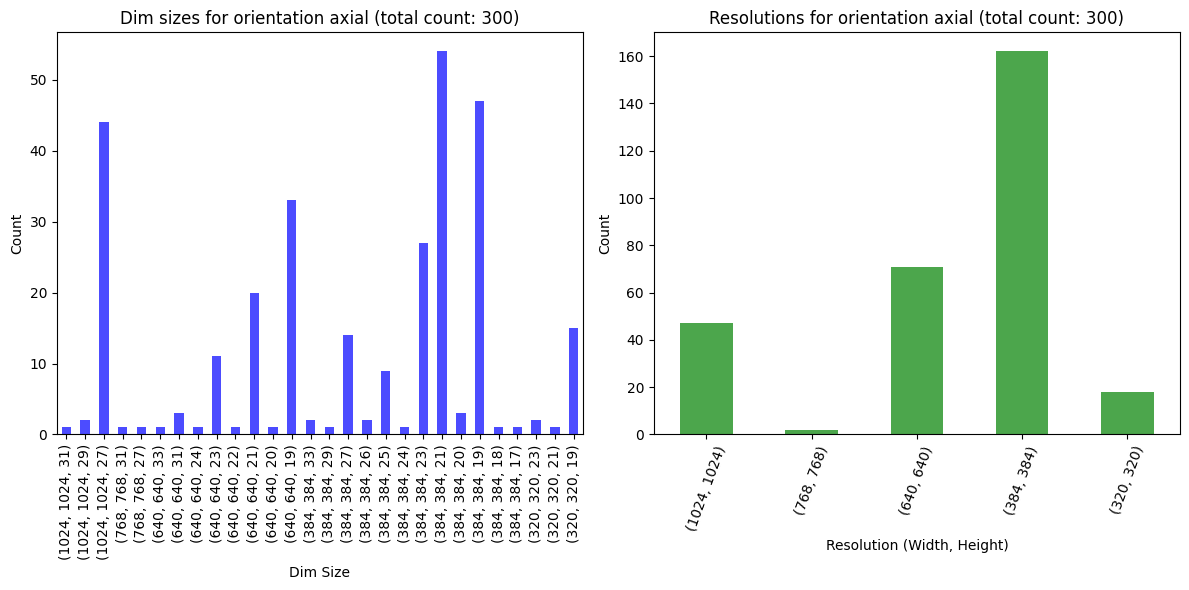

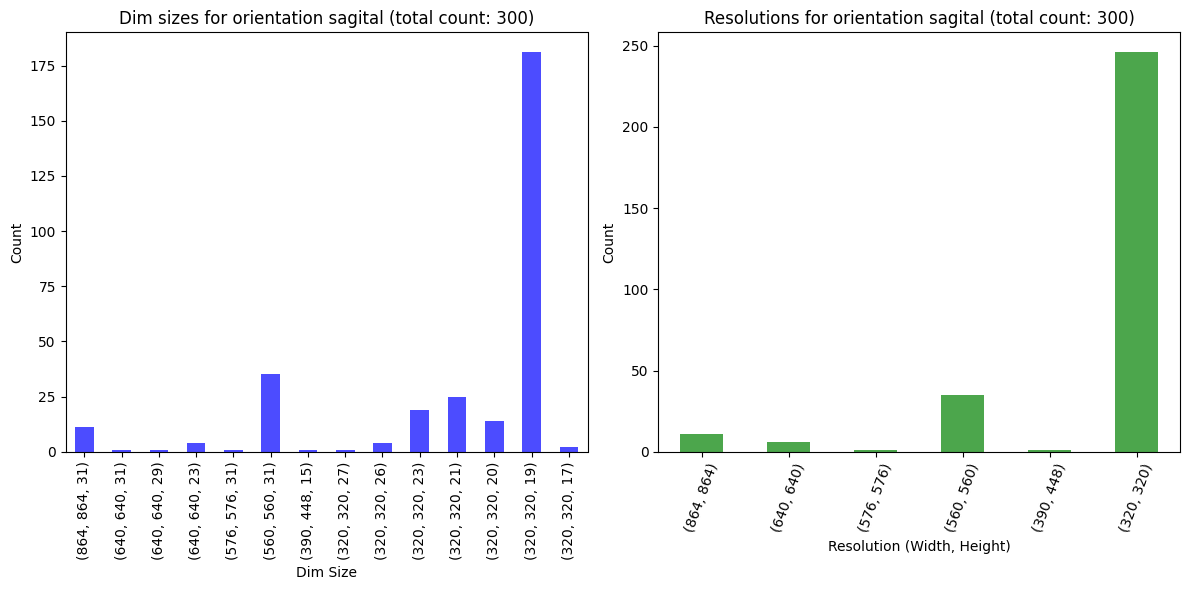

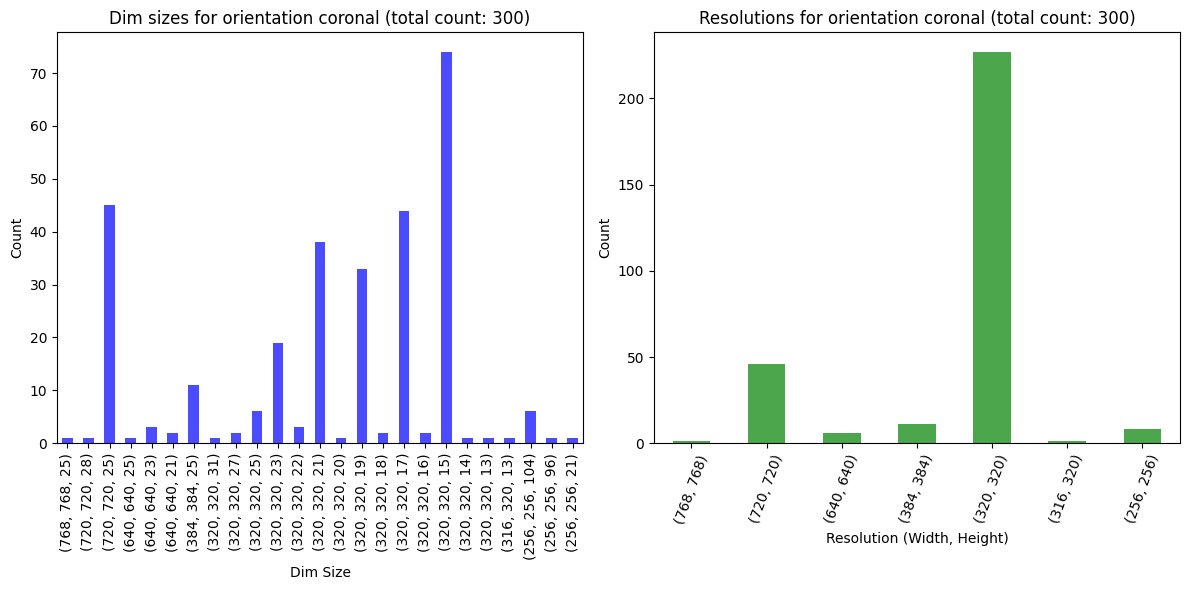

In [9]:
orientations = {"RAI" : "axial", "ASL" : "sagital", "RSA" : "coronal"}

for orientation, value in orientations.items():
    orientation_df = df[df['orientation'] == orientation]
    
    # Obtener el conteo de dim_size y ordenarlo
    dim_sizes = orientation_df['dim_size'].value_counts().sort_index(ascending=False)
    
    # Agrupar por resolución (ancho, alto) ignorando la profundidad
    resolution_counts = (
        orientation_df['dim_size']
        .apply(lambda x: (x[0], x[1]))  # Extraer solo (ancho, alto)
        .value_counts()
        .sort_index(ascending=False)
    )
    
    # Crear dos gráficos separados
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Dos gráficos lado a lado

    # Primer gráfico: dim_size
    dim_sizes.plot(kind='bar', ax=ax1, color='blue', alpha=0.7)
    ax1.set_title(f"Dim sizes for orientation {value} (total count: {dim_sizes.sum()})")
    ax1.set_xlabel("Dim Size")
    ax1.set_ylabel("Count")
    ax1.tick_params(axis='x', rotation=90)

    # Segundo gráfico: resolución (ancho, alto)
    resolution_counts.plot(kind='bar', ax=ax2, color='green', alpha=0.7)
    ax2.set_title(f"Resolutions for orientation {value} (total count: {resolution_counts.sum()})")
    ax2.set_xlabel("Resolution (Width, Height)")
    ax2.set_ylabel("Count")
    ax2.tick_params(axis='x', rotation=70)

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()

We will do a similar thing as the previous step, but now we will use the spacing data to see the voxel size of the images.

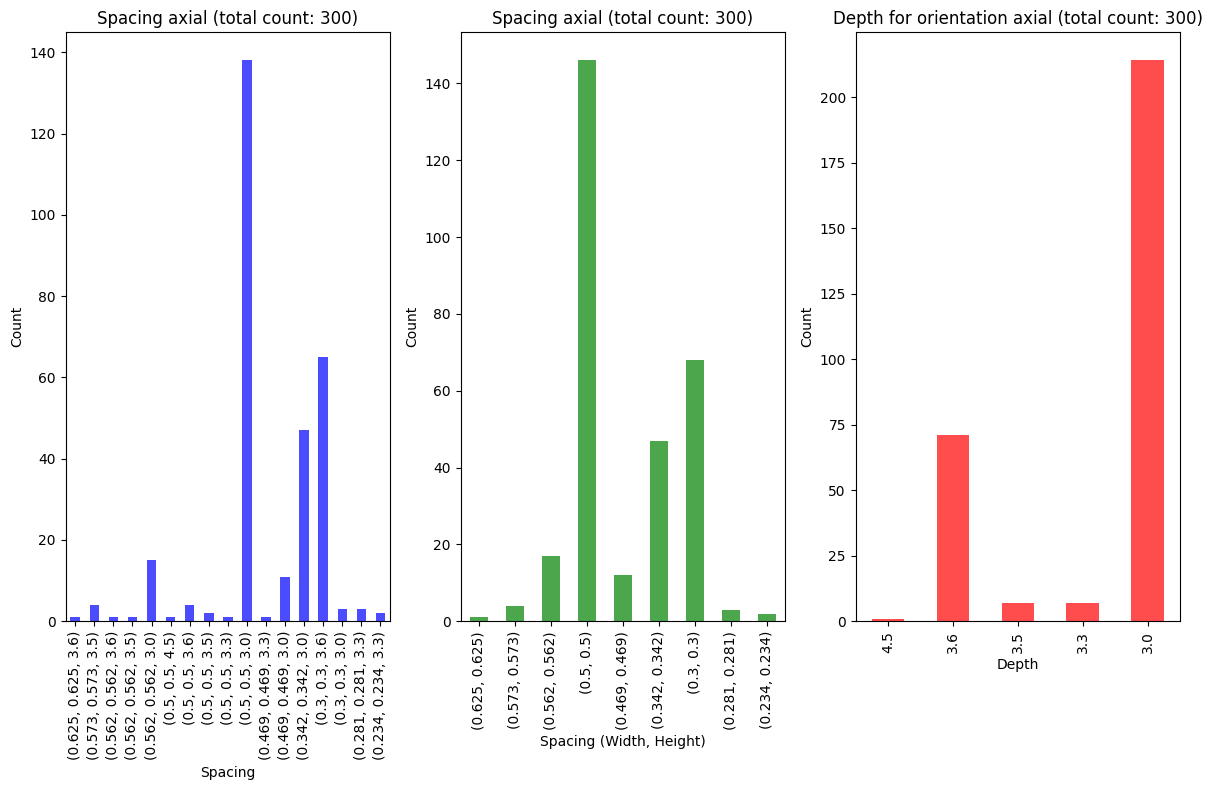

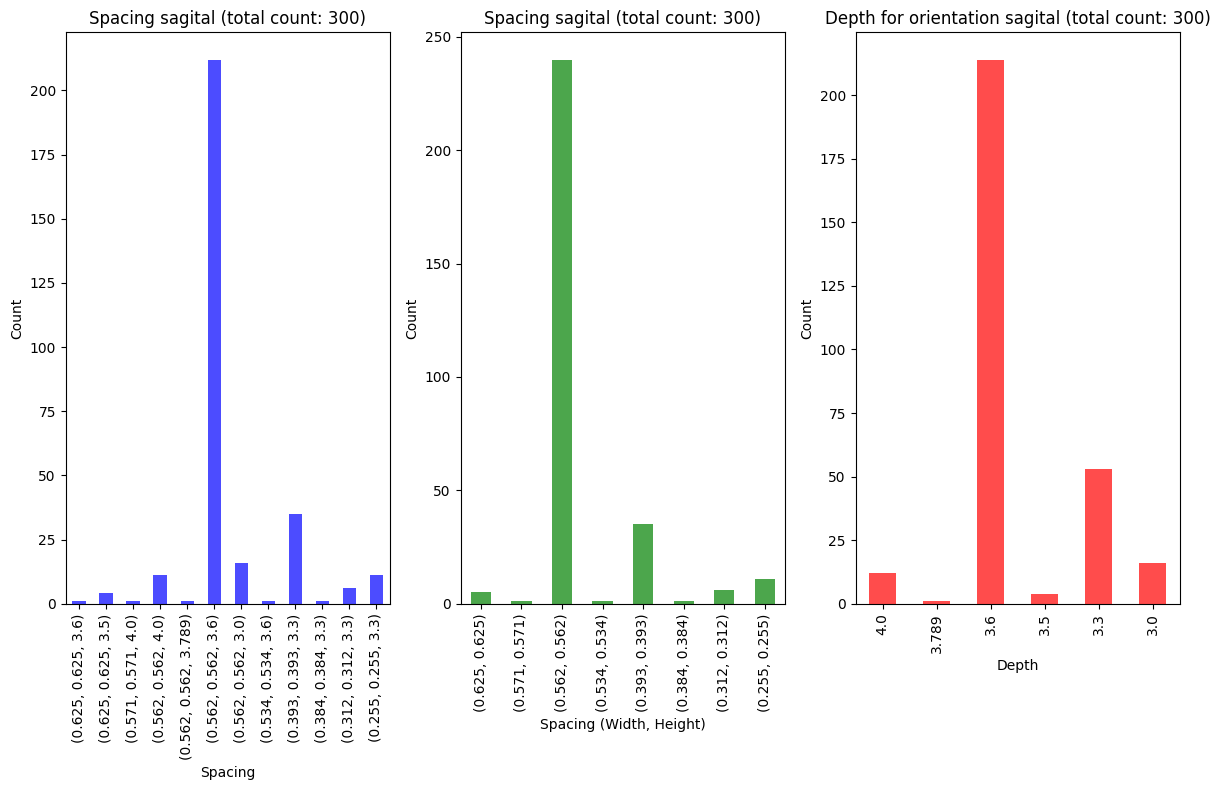

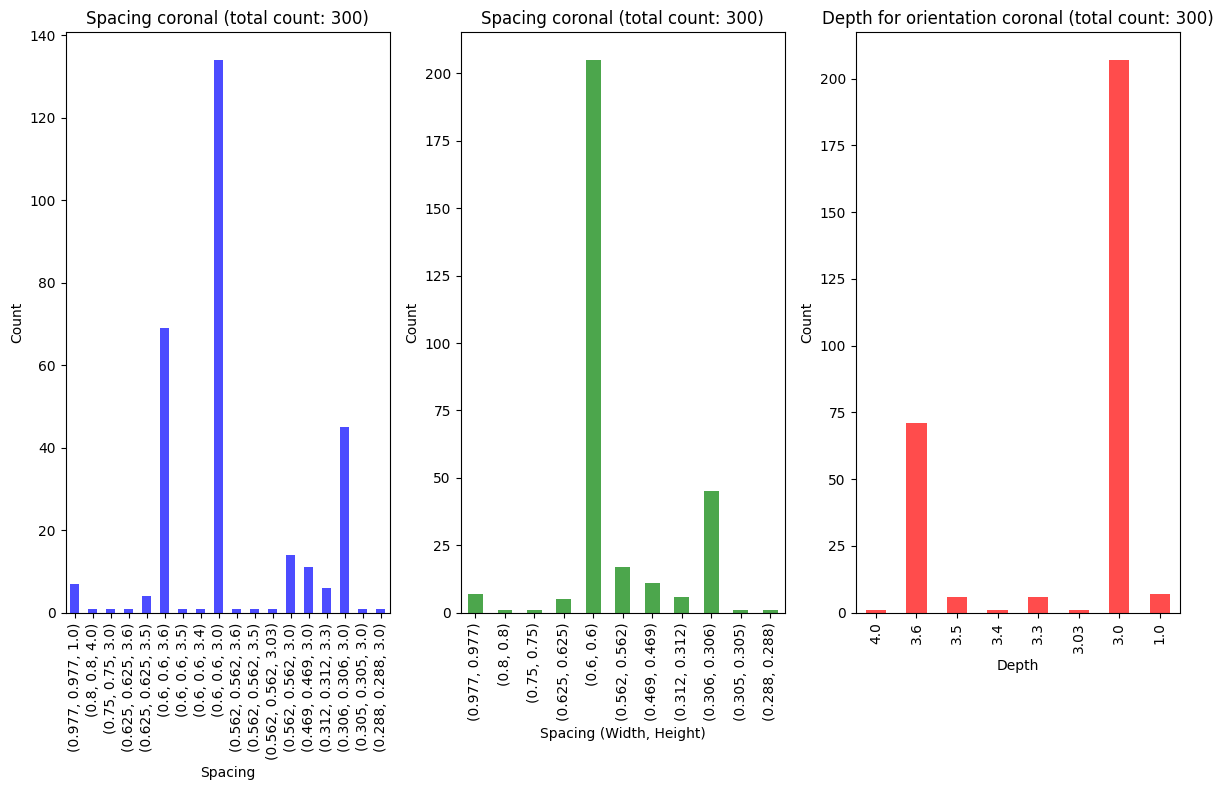

In [ ]:
orientations = {"RAI" : "axial", "ASL" : "sagital", "RSA" : "coronal"}

for orientation, value in orientations.items():
    orientation_df = df[df['orientation'] == orientation]
    
    dim_sizes = orientation_df['spacing'].value_counts().sort_index(ascending=False)
    
    # Agrupar por resolución (ancho, alto) ignorando la profundidad
    resolution_counts = (
        orientation_df['spacing']
        .apply(lambda x: (x[0], x[1]))  # Extraer solo (ancho, alto)
        .value_counts()
        .sort_index(ascending=False)
    )

    # agrupar por la profundidad de la imagen
    depth_counts = (
        orientation_df['spacing']
        .apply(lambda x: (x[2]))  # Extraer solo la profundidad
        .value_counts()
        .sort_index(ascending=False)
    )
    
    
    # Crear dos gráficos separados
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))  # Dos gráficos lado a lado

    # Primer gráfico: dim_size
    dim_sizes.plot(kind='bar', ax=ax1, color='blue', alpha=0.7)
    ax1.set_title(f"Spacing {value} (total count: {dim_sizes.sum()})")
    ax1.set_xlabel("Spacing")
    ax1.set_ylabel("Count")
    ax1.tick_params(axis='x', rotation=90)

    # Segundo gráfico: resolución (ancho, alto)
    resolution_counts.plot(kind='bar', ax=ax2, color='green', alpha=0.7)
    ax2.set_title(f"Spacing {value} (x,y) (total count: {resolution_counts.sum()})")
    ax2.set_xlabel("Spacing (Width, Height)")
    ax2.set_ylabel("Count")
    ax2.tick_params(axis='x', rotation=90)

    # Tercer gráfico: profundidad
    depth_counts.plot(kind='bar', ax=ax3, color='red', alpha=0.7)
    ax3.set_title(f"Depth for orientation {value} (total count: {depth_counts.sum()})")
    ax3.set_xlabel("Depth")
    ax3.set_ylabel("Count")
    ax3.tick_params(axis='x', rotation=90)

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()

We must also check the image pixel intensities for normalization.

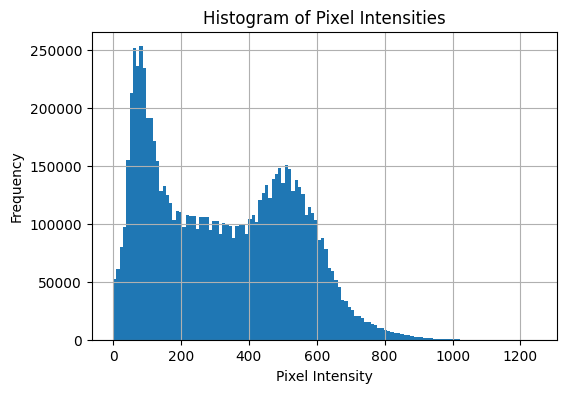

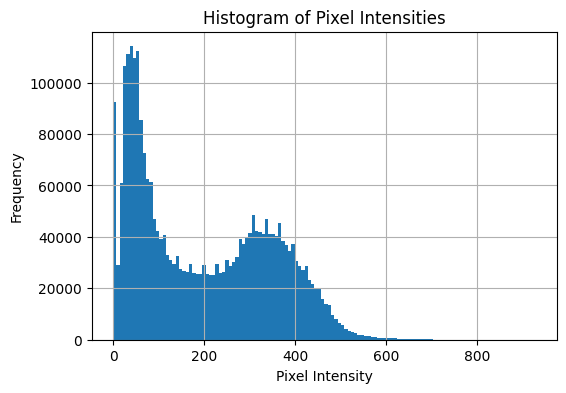

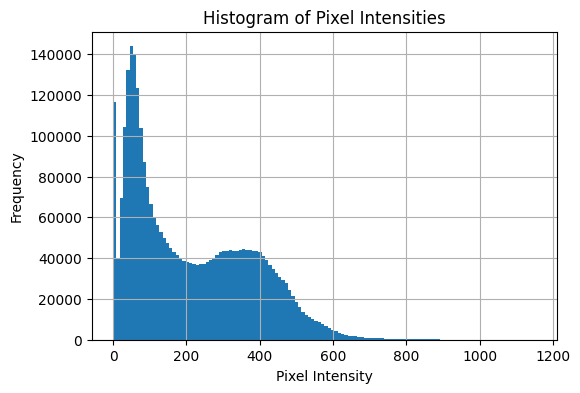

In [11]:
# plot pixel intensity histograms for a random selection of images

d = "picai_folds/picai_images_fold0"
dirs = list(analyzer.get_dirs(d))
random_dir = random.choices(dirs, k=3)


for idx, dir in enumerate(random_dir):
    files_in_dir = analyzer.get_files(join(d, dir), ".*_t2w.mha$")

    # We have to do this because get_files is a generator
    name = list(files_in_dir)[0]
    i1 = join(d, dir, name)

    analyzer.image_intensity_histogram(i1, plot = True)    